# Evaluate likelihood ratio

In [1]:
import sys, os
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2

import paper_settings

## Data

In [2]:
filenames = [
    "alices_fix",
    "alices_align",
    "alices_mass",
    "alices_full",
]
settings = ["fix", "align", "mass", "full"]
labels = ["Fix", "Align", "Mass", "Full"]
colors = [paper_settings.COLOR_FIX, paper_settings.COLOR_ALIGN, paper_settings.COLOR_MASS, paper_settings.COLOR_FULL]
lss = ["--", ":", "-.", "-"]

nmethods = len(filenames)
i_show = 3


In [3]:
llrs = []
llrs_cal = []

for filename in filenames:
    try:
        llrs.append(np.load("../data/results/llr_{}_grid.npy".format(filename)))
    except FileNotFoundError:
        print(filename, "not found")
        llrs.append(np.zeros((625, 100000)))
        
    try:
        llrs_cal.append(np.load("../data/results/llr_calibrated_{}_grid.npy".format(filename)))
    except (FileNotFoundError, ValueError):
        print("Calibrated", filename, "not found")
        llrs_cal.append(np.zeros((625, 100000)))
        
llrs = np.asarray(llrs)
llrs_cal = np.asarray(llrs_cal)

expected_llr = np.mean(llrs, axis=-1)
expected_llr_cal = np.mean(llrs_cal, axis=-1)


Calibrated alices_fix not found
Calibrated alices_align not found
Calibrated alices_mass not found
Calibrated alices_full not found


In [4]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## 2D likelihood map

In [5]:
llrmin, llrmax = 0.0, 25.
llr_cmap = "viridis_r"

llr = -2. * expected_llr[i_show]
llr -= np.min(llr)
i_mle = np.argmin(llr)
llr_clip = np.clip(llr, llrmin, llrmax)
sqrt_llr = np.sqrt(llr_clip)

n_for_lines = [100, 20, 5, 1]
thresholds = [1. / n * chi2.isf(0.05, df=2) for n in n_for_lines]
contour_ls = ["-", "--", "-.", ":"]
clabels = ["100", "20", "5", "1"]


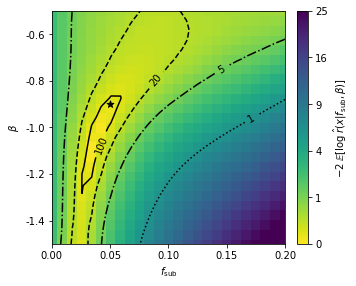

In [6]:
fig, (ax, cax) = paper_settings.figure(
    cbar=True, height=4.0,
    large_margin=0.15, small_margin=0.04, cbar_sep=0.04, cbar_width=0.04
)

plt.sca(ax)
pcm = ax.pcolormesh(
    alpha_edges,
    beta_edges,
    sqrt_llr.reshape((resolution, resolution)),
    norm=matplotlib.colors.Normalize(vmin=llrmin**0.5, vmax=llrmax**0.5),
    cmap=llr_cmap
)
cs = ax.contour(
    0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
    0.5 * (beta_edges[1:] + beta_edges[:-1]),
    llr.reshape((resolution, resolution)),
    thresholds,
    colors="black",
    linewidths=1.5,
    linestyles=contour_ls,
)
ax.scatter(0.05, -1.9, s=50., color='black', marker='*')
# ax.scatter(theta_grid[i_mle][0], theta_grid[i_mle][1], s=20., color='black', marker='o')

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$\beta$')
plt.xlim(0.,0.2)
plt.ylim(-2.5,-1.5) 
plt.xticks([0.,0.05,0.1,0.15,0.2])
plt.yticks([-1.6,-1.8,-2.0,-2.2,-2.4],["-0.6", "-0.8", "-1.0", "-1.2", "-1.4"])
plt.clabel(cs, fmt={thresholds[i] : clabels[i] for i in range(len(thresholds))},
          manual=[(0.04,-2.07), (0.09,-1.8), (0.14,-1.7), (0.17,-1.95)])
 
cbar = fig.colorbar(
    pcm,
    cax=cax,
    ticks=[0.,1.,2.,3.,4.,5.],
    format=matplotlib.ticker.FuncFormatter(lambda x, _ : "{:.0f}".format(x**2))
)
cbar.set_label(r'$-2\; \mathbb{E}[\log \;\hat{r}(x | f_{\mathrm{sub}}, \beta)]$')
    
plt.savefig("../figures/expected_likelihood_map.pdf")


## 1D slice

In [7]:
i_beta = 14
llr = -2. * expected_llr[i_show]
llr = llr.reshape((resolution, resolution))[i_beta, :]
llr -= np.min(llr)

n_for_lines = [100, 20, 5, 1]
thresholds = [1. / n * chi2.isf(0.05, df=2) for n in n_for_lines]
contour_ls = ["-", "--", "-.", ":"]
clabels = ["100", "20", "5", "1"]

thresholds


[0.05991464547107983,
 0.29957322735539915,
 1.1982929094215966,
 5.991464547107983]

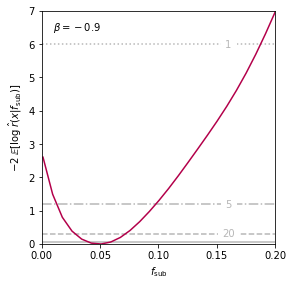

In [8]:
i_beta = 14

fig, ax = paper_settings.figure(
    cbar=False, height=4.0,
    large_margin=0.15, small_margin=0.04
)

plt.plot(f_sub_1d, llr, ls="-", c=paper_settings.COLOR_FULL)

for threshold, ls, label in zip(thresholds[::-1], contour_ls[::-1], clabels[::-1]):
    if label == "100":
        plt.plot([0.,0.2], [threshold, threshold], ls=ls, c=paper_settings.COLOR_BKG, zorder=-21)
        #plt.text(
        #    0.18, 0.1, label,
        #    color=paper_settings.COLOR_BKG, backgroundcolor="white",
        #    zorder=-23, ha="center", va="center"
        #)
    else:
        plt.plot([0.,0.2], [threshold, threshold], ls=ls, c=paper_settings.COLOR_BKG, zorder=-24)
        plt.text(
            0.16, threshold, label,
            color=paper_settings.COLOR_BKG, backgroundcolor="white",
            zorder=-22, ha="center", va="center"
        )

plt.text(x=0.01,y=6.7, ha="left", va="top", s=r"$\beta=-0.9$")

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$-2\; \mathbb{E}[\log \;\hat{r}(x | f_{\mathrm{sub}})]$')
plt.xlim(0., 0.2)
plt.ylim(0., 7)
#plt.xticks([0.,0.02,0.04,0.06, 0.08, 0.10, 0.12, 0.14])
    
plt.savefig("../figures/expected_likelihood_slice.pdf")


## Comparison plot 2D

In [9]:
n_for_lines = 5
threshold = 1. / n_for_lines * chi2.isf(0.05, df=2)

label_positions = [(0.1,-1.6), (0.03,-1.75), (0.05,-1.6), (0.01,-1.6)]

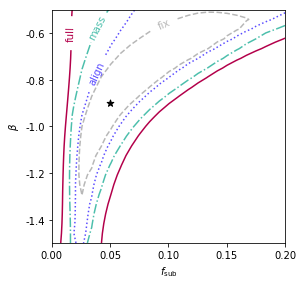

In [10]:
fig, ax = paper_settings.figure(
    cbar=False, height=4.0,
    large_margin=0.15, small_margin=0.04, cbar_sep=0.04, cbar_width=0.04
)

for i, (llr, label, color, ls, label_pos) in enumerate(zip(expected_llr, labels, colors, lss, label_positions)):
    llr = -2. * llr
    llr -= np.min(llr)
    cs = ax.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        llr.reshape((resolution, resolution)),
        [threshold],
        colors=color,
        linewidths=1.5,
        linestyles=ls,
    )
    plt.clabel(cs, fmt={threshold : label.lower()}, manual=[label_pos])
ax.scatter(0.05, -1.9, s=50., color='black', marker='*')

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$\beta$')
plt.xlim(0.,0.2)
plt.ylim(-2.5,-1.5) 
plt.xticks([0.,0.05,0.1,0.15,0.2])
plt.yticks([-1.6,-1.8,-2.0,-2.2,-2.4],["-0.6", "-0.8", "-1.0", "-1.2", "-1.4"])
    
plt.savefig("../figures/scenarios_2d.pdf")


## Comparison plot 1D slice

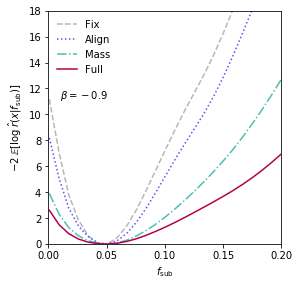

In [11]:
i_beta = 14

fig, ax = paper_settings.figure(
    cbar=False, height=4.0,
    large_margin=0.15, small_margin=0.04
)

for i, (llr, label, color, ls, label_pos) in enumerate(zip(expected_llr, labels, colors, lss, label_positions)):
    llr = -2. * llr
    llr = llr.reshape((resolution, resolution))[i_beta, :]
    llr -= np.min(llr)

    plt.plot(f_sub_1d, llr, ls=ls, label=label, c=color)

plt.text(x=0.01,y=12, ha="left", va="top", s=r"$\beta=-0.9$")
plt.legend(loc="upper left", frameon=False)

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$-2\; \mathbb{E}[\log \;\hat{r}(x | f_{\mathrm{sub}})]$')
plt.xlim(0., 0.2)
plt.ylim(0., 18.)
#plt.xticks([0.,0.02,0.04,0.06, 0.08, 0.10, 0.12, 0.14])
    
plt.savefig("../figures/scenarios_1d.pdf")

